In [91]:
import sys  
sys.path.insert(0, './machine_learning_models')

import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from helpers.file import save_file
from joblib import dump
pd.set_option('mode.chained_assignment', None)

In [92]:
first_season = 2012
last_season = 2023

save_models = True

season_file = f'{first_season}-{last_season}'

min_odds = 1.8

first_attr_index = 6
target_index = -3

In [93]:
print('\nGetting data for the model...')

dataset = pd.read_csv('../data/{}.csv'.format(season_file), index_col = 0)
dataset = dataset.loc[(dataset['ODDS_A'].notna()) & (dataset['ODDS_B'].notna())]
dataset['GAME_DATE'] = pd.to_datetime(dataset['GAME_DATE']).dt.date

display(dataset.tail(2))


Getting data for the model...


,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER,GAME_PTS_A,GAME_PTS_B
11047,2023,2024-01-22,ORL,CLE,2.12,1.75,109.066667,111.666667,0.454133,0.349533,...,0.7,0.588235,7,0.800000,0.6,118.232569,107.509545,A,99,126
11048,2023,2024-01-22,PHI,SAS,1.76,2.11,114.800000,111.866667,0.466467,0.358667,...,0.2,0.217391,1,0.266667,0.4,112.688511,116.124604,H,133,123


In [94]:
# dependent_variables = dataset.iloc[:,first_attr_index:]
# dependent_variables.corr()

In [95]:
def train_predict_model(x_train, y_train, x_test, y_test, season, model):
    model_abbv = model['abbreviation']
    classifier = model['classifier']
    
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    predictions_probabilities = classifier.predict_proba(x_test)
    
    if save_models and season == last_season:
        save_file('../models', classifier, model_abbv)
    
    results_df = pd.DataFrame({
        f"{model_abbv}_PRED": predictions,
        f"{model_abbv}_PROBS_A": predictions_probabilities[:, 1],
        f"{model_abbv}_PROBS_B": predictions_probabilities[:, 0],
    })
    
    return results_df

In [96]:
columns = dataset.columns[first_attr_index:target_index]

columns_to_drop = []
columns = [c for c in columns if c not in columns_to_drop]

target_col = dataset.columns[target_index]

print('Columns:', columns)
print('Target:', target_col)

Columns: ['PTS_A', 'PTS_CON_A', 'FG_PCT_A', 'FG3_PCT_A', 'FT_PCT_A', 'REB_A', 'TOV_A', 'SEASON_A_PCT', 'PER_A', 'ELO_A', 'MATCHUP_A_PCT', 'HA_A_PCT', 'STREAK_A', 'LAST_GAMES_PCT_A', 'HA_LAST_GAMES_PCT_A', 'OFF_RTG_A', 'DEF_RTG_A', 'PTS_B', 'PTS_CON_B', 'FG_PCT_B', 'FG3_PCT_B', 'FT_PCT_B', 'REB_B', 'TOV_B', 'SEASON_B_PCT', 'PER_B', 'ELO_B', 'MATCHUP_B_PCT', 'HA_B_PCT', 'STREAK_B', 'LAST_GAMES_PCT_B', 'HA_LAST_GAMES_PCT_B', 'OFF_RTG_B', 'DEF_RTG_B']
Target: WINNER


In [105]:
main_df = pd.DataFrame()

for season in range(first_season + 1, last_season+1):
    rf_classifier = RandomForestClassifier(n_estimators=500, random_state=0)
    gb_classifier = GradientBoostingClassifier(random_state=0)
    lr_classifier = LogisticRegression()
    svm_classifier = SVC(kernel='rbf', random_state=0, probability=True)
    sgd_classifier = SGDClassifier(loss="log", random_state = 0)

    # Create a voting classifier
    voting_classifier = VotingClassifier(
        estimators=[
            ('LR', lr_classifier),
            ('GB', gb_classifier),
            ('RF', rf_classifier),
        ],
        voting='soft'  # Use 'soft' for probability voting
    )
    
    models = [
        {'classifier': rf_classifier, 'abbreviation': 'RF'},
        {'classifier': RandomForestClassifier(n_estimators=200, random_state=0), 'abbreviation': 'RF_200'},
        {'classifier': RandomForestClassifier(n_estimators=800, random_state=0), 'abbreviation': 'RF_800'},
        {'classifier': gb_classifier, 'abbreviation': 'GB'},
        {'classifier': svm_classifier, 'abbreviation': 'SVM'},
        {'classifier': lr_classifier, 'abbreviation': 'LR'},
        {'classifier': voting_classifier, 'abbreviation': 'VC'},
        {'classifier': GaussianNB(), 'abbreviation': 'NB'},
        {'classifier': KNeighborsClassifier(n_neighbors=500), 'abbreviation': 'KNN'},
        {'classifier': sgd_classifier, 'abbreviation': 'SGD'}, 
    ]

    train_dataset = dataset[dataset['SEASON_ID'] < season]
    x_train = train_dataset[columns]
    y_train = train_dataset[target_col]

    test_dataset = dataset[dataset['SEASON_ID'] == season]
    x_test = test_dataset[columns]
    y_test = test_dataset[target_col]

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if save_models and season == last_season:
        save_file('../scalers', scaler, 'scaler')
    
    for model in models:
        clear_output(wait=True)
        
        model_abbv = model["abbreviation"]
        print(f"{season}/{last_season} - {model_abbv}")
        
        results_df = train_predict_model(x_train_scaled, y_train, x_test_scaled, y_test, season, model)
        results_df.set_index(test_dataset.index, inplace=True)
        
        test_dataset = pd.merge(test_dataset, results_df, left_index=True, right_index=True)

    if main_df.empty:
        main_df = test_dataset
    else:
        main_df = pd.concat([main_df, test_dataset], ignore_index=True)

2023/2023 - SGD


In [106]:
def create_game_profit_col(row, model_abbv):
    odds = row["ODDS_A" if row[f"{model_abbv}_PRED"] == "H" else "ODDS_B"]
    pred_odds = 1 / (
        row[
            f"{model_abbv}_PROBS_A"
            if row[f"{model_abbv}_PRED"] == "H"
            else f"{model_abbv}_PROBS_B"
        ]
    )
    probs = row[
        f"{model_abbv}_PROBS_A"
        if row[f"{model_abbv}_PRED"] == "H"
        else f"{model_abbv}_PROBS_B"
    ]

    bet_valid = odds > min_odds and pred_odds < odds

    if bet_valid and row["WINNER"] == row[f"{model_abbv}_PRED"]:
        return odds - 1
    elif bet_valid:
        return -1
    else:
        return 0


display(main_df.head(2))

in_depth_models_for_analysis = ["RF", "RF_500", "GB", "SVM", "LR", "VC", "SGD"]

# Initialize an empty DataFrame to store season-wise statistics
season_stats = pd.DataFrame(columns=["Season"])

for model in models:
    model_abbv = model["abbreviation"]

    main_df[f"{model_abbv}_PROFIT"] = main_df.apply(
        lambda x: create_game_profit_col(x, model_abbv), axis=1
    )
    main_df[f"{model_abbv}_PROFIT_TRACKING"] = main_df[f"{model_abbv}_PROFIT"].cumsum()
    main_df[f"{model_abbv}_STRIKE"] = (
        main_df[f"{model_abbv}_PRED"] == main_df["WINNER"]
    ).astype(int)

    # Calculate Net Gains
    net_gains = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]

    # Calculate Yield
    total_profit = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]
    total_bets = len(main_df)
    yield_percentage = (total_profit / total_bets) * 100

    # Calculate Strike Rate
    correct_predictions = main_df[f"{model_abbv}_STRIKE"].sum()
    strike_rate_percentage = (correct_predictions / total_bets) * 100

    # Print the results
    print(f"\n{model_abbv} Net Gains: {net_gains}")
    print(f"{model_abbv} Yield: {yield_percentage:.2f}%")
    print(f"{model_abbv} Strike Rate: {strike_rate_percentage:.2f}%")

    if model_abbv not in in_depth_models_for_analysis:
        continue

    # Group by season and calculate overall stats
    model_season_stats = main_df.groupby("SEASON_ID").agg(
        {
            f"{model_abbv}_PROFIT_TRACKING": lambda x: x.iloc[-1] - x.iloc[0],
            f"{model_abbv}_PROFIT": lambda x: (
                x != 0
            ).sum(),  # Counting only non-zero profits as bets
        }
    )

    # Rename columns for clarity
    model_season_stats.columns = [f"{model_abbv}_Net_Gains", f"{model_abbv}_Total_Bets"]

    # Calculate additional statistics
    model_season_stats[f"{model_abbv}_Yield"] = (
        model_season_stats[f"{model_abbv}_Net_Gains"]
        / model_season_stats[f"{model_abbv}_Total_Bets"]
    ) * 100

    # Merge with the overall season_stats DataFrame
    season_stats = pd.merge(
        season_stats,
        model_season_stats,
        left_on="Season",
        right_index=True,
        how="outer",
    )

season_stats.drop("Season", axis=1, inplace=True)

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,VC_PROBS_B,NB_PRED,NB_PROBS_A,NB_PROBS_B,KNN_PRED,KNN_PROBS_A,KNN_PROBS_B,SGD_PRED,SGD_PROBS_A,SGD_PROBS_B
0,2013,2013-11-27,HOU,ATL,1.26,3.96,108.733333,104.266667,0.486933,0.348533,...,0.202191,H,0.999088,0.000912,H,0.688,0.312,H,0.993555,0.006445
1,2013,2013-11-27,DAL,GSW,1.52,2.58,105.666667,103.666667,0.473267,0.386933,...,0.373191,H,0.842290,0.157710,H,0.598,0.402,A,0.195978,0.804022



RF Net Gains: 113.88000000000007
RF Yield: 1.13%
RF Strike Rate: 65.43%

RF_200 Net Gains: 131.2199999999998
RF_200 Yield: 1.31%
RF_200 Strike Rate: 65.39%

RF_800 Net Gains: 146.0199999999997
RF_800 Yield: 1.45%
RF_800 Strike Rate: 65.65%

GB Net Gains: 164.3499999999997
GB Yield: 1.63%
GB Strike Rate: 65.20%

SVM Net Gains: 73.28000000000007
SVM Yield: 0.73%
SVM Strike Rate: 64.97%

LR Net Gains: 101.99000000000012
LR Yield: 1.01%
LR Strike Rate: 65.86%

VC Net Gains: 173.1999999999996
VC Yield: 1.72%
VC Strike Rate: 66.33%

NB Net Gains: 142.5699999999999
NB Yield: 1.42%
NB Strike Rate: 65.30%

KNN Net Gains: 56.08999999999991
KNN Yield: 0.56%
KNN Strike Rate: 64.95%

SGD Net Gains: -11.750000000000048
SGD Yield: -0.12%
SGD Strike Rate: 62.18%


In [107]:
display(season_stats)

,RF_Net_Gains,RF_Total_Bets,RF_Yield,GB_Net_Gains,GB_Total_Bets,GB_Yield,SVM_Net_Gains,SVM_Total_Bets,SVM_Yield,LR_Net_Gains,LR_Total_Bets,LR_Yield,VC_Net_Gains,VC_Total_Bets,VC_Yield,SGD_Net_Gains,SGD_Total_Bets,SGD_Yield
SEASON_ID,,,,,,,,,,,,,,,,,,
2013,-18.48,194,-9.525773,-16.45,254,-6.476378,-35.29,221,-15.968326,-42.07,212,-19.844340,-28.74,200,-14.370000,-10.39,325,-3.196923
2014,18.58,175,10.617143,38.14,209,18.248804,29.74,184,16.163043,23.49,173,13.578035,38.19,172,22.203488,9.77,341,2.865103
2015,11.15,196,5.688776,-2.35,215,-1.093023,23.90,208,11.490385,35.93,167,21.514970,24.51,167,14.676647,-29.54,275,-10.741818
2016,40.68,194,20.969072,40.82,215,18.986047,29.59,227,13.035242,19.29,171,11.280702,30.78,189,16.285714,-5.91,244,-2.422131
2017,18.04,185,9.751351,-0.20,199,-0.100503,-4.31,207,-2.082126,11.62,172,6.755814,21.25,171,12.426901,-22.07,317,-6.962145
2018,21.42,173,12.381503,18.39,189,9.730159,18.39,214,8.593458,7.76,157,4.942675,17.75,161,11.024845,10.03,302,3.321192
2019,32.19,175,18.394286,42.36,186,22.774194,29.58,185,15.989189,25.14,169,14.875740,38.83,165,23.533333,10.87,347,3.132565
2020,-11.37,196,-5.801020,15.34,201,7.631841,3.70,193,1.917098,-1.31,182,-0.719780,7.48,181,4.132597,18.31,195,9.389744
2021,-12.35,179,-6.899441,6.91,173,3.994220,-27.46,191,-14.376963,-2.85,170,-1.676471,5.65,162,3.487654,-8.63,184,-4.690217


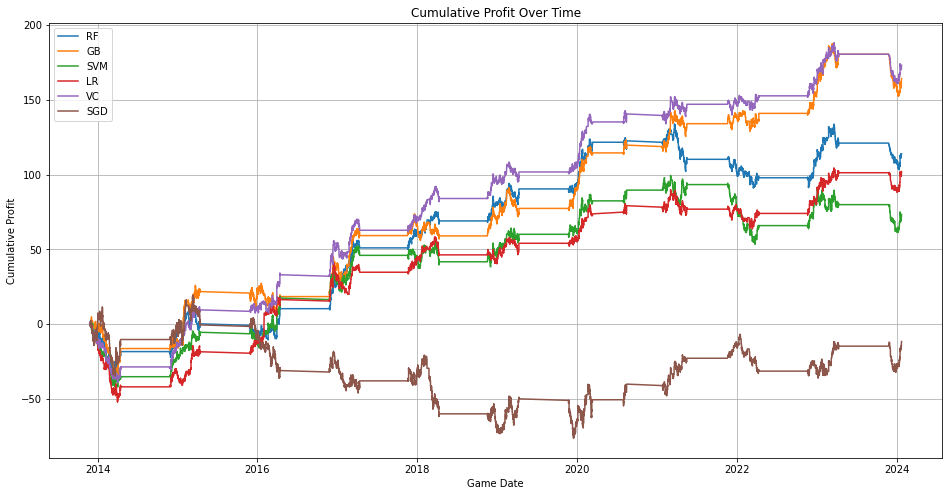

In [108]:
plt.figure(figsize=(16, 8))

for model in models:
    model_abbv = model["abbreviation"]
    if model_abbv in in_depth_models_for_analysis:
        plt.plot(main_df['GAME_DATE'], main_df[f"{model_abbv}_PROFIT_TRACKING"], label = model_abbv)
    
plt.title('Cumulative Profit Over Time')
plt.xlabel('Game Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)
plt.show()

#### 